In [2]:
import time
from copy import deepcopy

from utils import *
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
from data import LinkPredictDataset

from dhg import Hypergraph

In [3]:
import torch

# 检查是否有可用的 CUDA 设备
if torch.cuda.is_available():
    # 打印 CUDA 版本号
    print("CUDA 版本号:", torch.version.cuda)
    # 打印可用的 CUDA 设备数量
    print("可用的 CUDA 设备数量:", torch.cuda.device_count())
    # 打印当前 CUDA 设备的名称
    print("当前 CUDA 设备名称:", torch.cuda.get_device_name(0))
else:
    print("CUDA 不可用")


CUDA 版本号: 12.1
可用的 CUDA 设备数量: 1
当前 CUDA 设备名称: NVIDIA GeForce RTX 4090


In [30]:
msg_pass_ratio: float = 0.7
data_set = LinkPredictDataset("data_s10800_p5_t800_hs11_e50000", ratio=(msg_pass_ratio, 1-msg_pass_ratio), device=torch.device("cpu"))

In [31]:
print(f"original_hg : {zero_dergee_num(data_set.original_hg)}")
print(f"msg_pass_hg : {zero_dergee_num(data_set.msg_pass_hg)}")
print(f"pos_hg : {zero_dergee_num(data_set.pos_hg)}")
print(f"neg_hg : {zero_dergee_num(data_set.neg_hg)}")

original_hg : 0
msg_pass_hg : 0
pos_hg : 0
neg_hg : 0


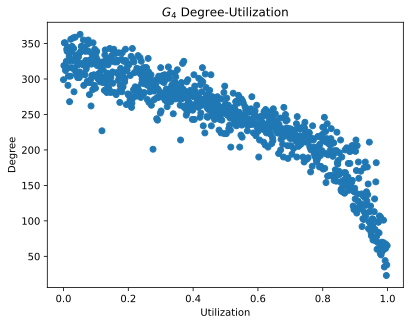

In [32]:
plot_dergee_utilization(data_set.original_hg, r'$G_4$ Degree-Utilization')

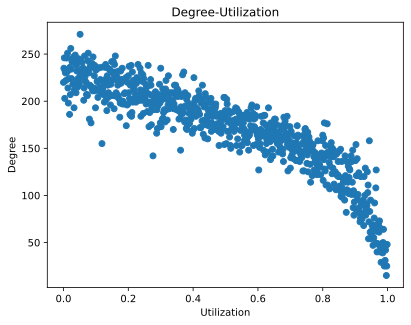

In [33]:
plot_dergee_utilization(data_set.msg_pass_hg)

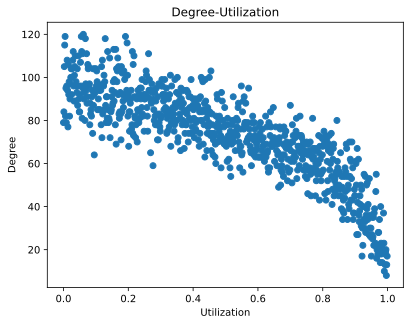

In [34]:
plot_dergee_utilization(data_set.pos_hg)

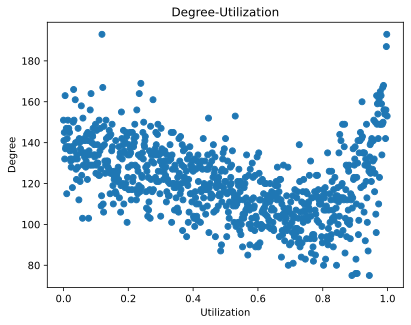

In [35]:
plot_dergee_utilization(data_set.neg_hg)